# 5. Implementing a GRU model

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.2 (06/07/2023)

**Requirements:**
- Python 3 (tested on v3.11.4)
- Matplotlib (tested on v3.7.1)
- Numpy (tested on v1.24.3)
- Torch (tested on v2.0.1+cu118)

### Imports and CUDA

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### The memory and GRU cell

The intuition behind the Gated Recurrent Unit (GRU) is to allow the model to selectively choose which information from the previous hidden state to retain and which to discard, in order to give more importance to recently predicted values for instance. It also helps to better handle the problem of vanishing gradients in RNNs. To do so, the GRU formula uses two gates, the update gate and the reset gate, to control the flow of information.

The update gate, represented by the equation 

$$ z_t = \sigma(W_z x_t + U_z h_{t-1} + b_z) $$

is used to decide what information to throw away from the previous hidden state, h_{t-1}. The value of $ z_t $ ranges between 0 and 1: a value of 0 means that the new hidden state will be entirely based on the new input, whereas a value of 1 means that the new hidden state will be entirely based on the previous hidden state.

The reset gate, represented by the equation

$$ r_t = \sigma(W_r x_t + U_r h_{t-1} + b_r) $$

is used to decide what information to keep from the previous hidden state. It also ranges between 0 and 1: a value of 0 means that the previous hidden state will be entirely discarded, whereas a value of 1 means that the previous hidden state will be entirely kept.

The new hidden state, $ h_t $, is then computed by:

$$ h_t = (1-z_t) * h_{t-1} + z_t * \tilde{h_t} $$

Where $ \tilde{h_t} $ denotes the candidate hidden state, defined as:

$$ \tilde{h_t} = \tanh(W_h x_t + U_h (r_t \odot h_{t-1}) + b_h) $$

The new hidden state, $ h_t $, is therefore a combination of the input, $ x_t $, and the previous hidden state $ h_{t-1} $, with the update gate, $ z_t $, and reset gate, $ r_t $, controlling the flow of information.

Finally, the output $ y_t $ supposed to match $ x_{t+1} $ is defined using the newly calculated hidden state, as:

$$ y_t = V h_t $$

To recap, the diagram of a GRU cell is shown below.

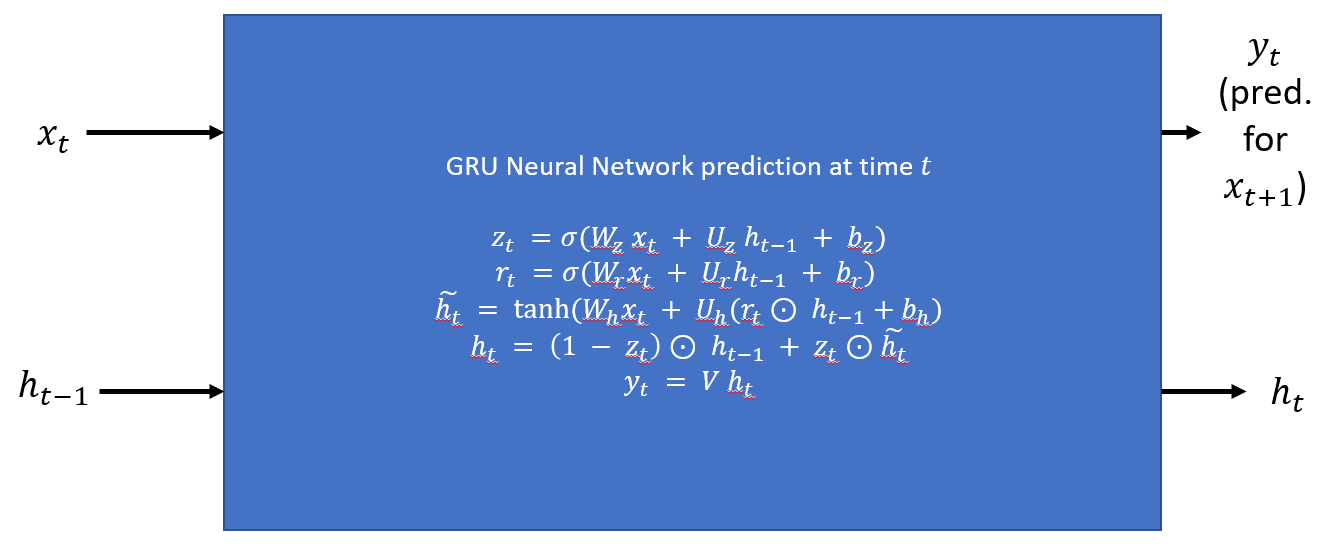

Its implementation, in Torch, is shown below.

In [3]:
class GRU(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Parameters for the reset gate
        self.Wr = torch.nn.Parameter(torch.randn(input_size, hidden_size))
        self.Ur = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.br = torch.nn.Parameter(torch.zeros(hidden_size))
        # Parameters for the update gate
        self.Wz = torch.nn.Parameter(torch.randn(input_size, hidden_size))
        self.Uz = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.bz = torch.nn.Parameter(torch.zeros(hidden_size))
        # Parameters for the candidate hidden state
        self.W = torch.nn.Parameter(torch.randn(input_size, hidden_size))
        self.U = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.b = torch.nn.Parameter(torch.zeros(hidden_size))

        # Parameters for the output prediction
        self.V = torch.nn.Parameter(torch.randn(hidden_size, output_size))
        self.b = torch.nn.Parameter(torch.randn(1, output_size))

    def forward(self, inputs, hidden):
        # Compute the reset gate
        reset_gate = torch.sigmoid(torch.matmul(inputs, self.Wr) + torch.matmul(hidden, self.Ur) + self.br)
        # Compute the update gate
        update_gate = torch.sigmoid(torch.matmul(inputs, self.Wz) + torch.matmul(hidden, self.Uz) + self.bz)

        # Compute the candidate hidden state
        candidate_hidden = torch.tanh(torch.matmul(inputs, self.W) + torch.matmul(reset_gate * hidden, self.U) + self.b)
        # Compute the updated hidden state
        new_hidden = (1 - update_gate) * hidden + update_gate * candidate_hidden

        # Compute the output
        output = torch.matmul(new_hidden, self.V) + self.b

        return new_hidden, output

In [4]:
# Testing out GRU model
gru = GRU(input_size = 1, hidden_size = 4, output_size = 1)
input_data = torch.from_numpy(np.random.randn(1, 1)).float()
h_data = torch.from_numpy(np.random.randn(1, 4)).float()
h_next_data = gru.forward(input_data, h_data)
print("New hidden state h size:", h_next_data[0].shape)
print("Predicted output y size:", h_next_data[1].shape)

New hidden state h size: torch.Size([1, 4])
Predicted output y size: torch.Size([1, 1])


### Define a GRU model

This time, using PyTorch. Note that you can specify a *num_layers* in the PyTorch GRU function.

It simply consists of the number of recurrent layers. e.g., setting num_layers = 2 would mean stacking two GRUs together to form a stacked GRU, with the second GRU taking in outputs of the first GRU and computing the final results.

By default, however, we will stick to only one layer.

In [5]:
class GRU_pt(torch.nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size, output_size):
        super(GRU_pt, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        
        # GRU cell
        self.gru = torch.nn.GRU(input_size, hidden_size, num_layers = 1, batch_first = True)
        # Output layer
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, inputs, hidden):
        # Forward pass through the GRU cell
        out, new_hidden = self.gru(inputs, hidden)
        # Apply the output layer 
        output = self.linear(out)
        return new_hidden, output

In [6]:
# Define the model parameters
input_size = 1
hidden_size = 16
num_layers = 1
output_size = 1
# Create the model
model = GRU_pt(input_size, hidden_size, num_layers, output_size).to(device)
print(model)

GRU_pt(
  (gru): GRU(1, 16, batch_first=True)
)


In [7]:
# Testing out GRU model
gru = GRU_pt(input_size = 1, hidden_size = 4, num_layers = 1, output_size = 1)
input_data = torch.from_numpy(np.random.randn(1, 1)).float()
h_data = torch.from_numpy(np.random.randn(1, 4)).float()
h_next_data = gru.forward(input_data, h_data)
print("New hidden state h size:", h_next_data[0].shape)
print("Predicted output y size:", h_next_data[1].shape)

New hidden state h size: torch.Size([1, 4])
Predicted output y size: torch.Size([1, 4])


### What's next?

The GRU model above is ready to be trained as in NB3!

In the next notebook, we will investigate the LSTM model, an alternative to the GRU one.